# 【开源实习】深度展开鲁棒量子启发式算法

## 1 任务背景

量子启发式算法应用中绝热演化路径对优化结果和计算时间影响较大，目前主要依赖人工经验调节，成为应用痛点。深度展开技术可以从数据集中自动学习绝热演化参数，可以提高量子启发式算法的鲁棒性、求解效果并减少迭代步数，有望推动更多应用落地。

## 2 任务需求及实现方案

基于MindQuantum设计实现一套基于深度展开的鲁棒量子启发式算法，该算法分训练和推理两个阶段，经过QUBO数据集上训练后，期望在同类QUBO问题上推理阶段的质量和速度显著提高，且全程无需人工调参。

### 深度展开模拟分岔机

本项目采用弹道模拟分岔机算法(ballistic simulated bifurcation, bSB)作为基线方法，在此基础上，首先将bSB算法转换为可微的形式，然后构建张量网络通过梯度下降的方法更新超参数，建立深度展开bSB算法(deep unfolding bSB, DUSB)。

## 3 算法实现及效果

下面基于 MindSpore Quantum 实现该算法。

### 3.1 数据集介绍

设置决策变量数为12，分别以固定值，均匀分布和双峰分布随机生成变量之间的相关系数。在每种方式下生成的相关系数可以表示变量之间的相互作用，也可以表示变量自身的偏置项。具体来说，对两个不同变量之间的耦合关系构成 Ising 问题中的矩阵J，而对单个变量自身的偏置项构成向量h。该问题的目标是计算Ising模型能量值最小。为评估不同算法在该问题上的求解性能，我们使用商业数学优化求解器 Gurobi 作为精确基准。对于每一个随机生成的实例，Gurobi 被用于计算该 Ising 模型的全局最优解，即最优的自选配置z和最小的能量值H。这些解不仅为模型评估提供准确的参考，也作为监督学习方法中的训练标签。随机生成900个案例，其中810个用于训练DUSB的超参数，其余90个作为测试集比较算法性能。

In [1]:
import itertools
import random
import numpy as np
import json
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
import torch.storage
from pathlib import Path
from argparse import ArgumentParser
from typing import List, Tuple
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from numpy import ndarray
import re
from mindquantum.algorithm.qaia import QAIA, BSB
import time

In [2]:
Nq = 12
def generate_hyperedges(n, k, portion=0.2):
    hyperedges = []
    for i in range(1, k + 1):
        for combination in itertools.combinations(range(n), i):
            hyperedges.append(tuple(combination))
    num_hyperedges = len(hyperedges)
    num_to_select = int(num_hyperedges * portion)
    random_hyperedges = random.sample(hyperedges, num_to_select)
    return random_hyperedges
def set_coef(hyperedges, coef="std"):
    model = {"J": [], "c": []}
    for edge in hyperedges:
        model["J"].append(list(edge))
        if coef == "std":
            model["c"].append(5)
        elif coef == "uni":
            model["c"].append(random.uniform(-5, 5))
        elif coef == "exp":
            model["c"].append(random.expovariate(1))
        elif coef == "bimodal":
            s1 = np.random.normal(1, 1)
            s2 = np.random.normal(10, 1)
            model["c"].append(np.random.choice([s1, s2]))
    return model
def generate_data(Nq=Nq, kmax=2, p=0.2, nr=90, tort="train"):
    random.seed(2025)
    np.random.seed(2025)
    for k in range(2, kmax + 1):
        for r in range(nr):
            hyperedges = generate_hyperedges(Nq, k, portion=p)
            for coef in ["std", "uni", "bimodal"]:
                model = set_coef(hyperedges, coef=coef)
                model_str = json.dumps(model)
                directory = f"{tort}_dataset"
                if not os.path.exists(directory):
                    os.makedirs(directory)
                with open(f"{tort}_dataset/{coef}_p{p}_{r}.json", "w") as f:
                    f.write(model_str)
# 生成训练集 90 * 9 = 810 个案例
generate_data(p=0.3, nr=90, tort="train")
generate_data(p=0.6, nr=90, tort="train")
generate_data(p=0.9, nr=90, tort="train")
# 生成测试集 10 * 9 = 90 个案例
generate_data(p=0.3, nr=10, tort="test")
generate_data(p=0.6, nr=10, tort="test")
generate_data(p=0.9, nr=10, tort="test")
print("数据集生成完毕")

数据集生成完毕


In [3]:
import gurobipy as gp
from gurobipy import GRB
def solve_ising_instance(instance, N=12):
    # 创建 Gurobi 模型并禁用日志输出
    m = gp.Model("ising_k2")
    m.setParam("OutputFlag", 0)
    # 创建 N 个二元变量 x[i] ∈ {0,1}
    x = m.addVars(N, vtype=GRB.BINARY, name="x")
    # 构造目标函数（使用二次表达式）
    obj = gp.QuadExpr()
    constant = 0.0
    # 遍历对应的系数
    for edge, coef in zip(instance["J"], instance["c"]):
        if len(edge) == 1:
            # 1阶项: coef * (2*x[i] - 1)
            i = edge[0]
            obj.add(2 * coef * x[i])
            constant += -coef
        elif len(edge) == 2:
            # 2阶项: coef * (4*x[i]*x[j] - 2*x[i] - 2*x[j] + 1)
            i, j = edge[0], edge[1]
            obj.add(4 * coef * x[i] * x[j])
            obj.add(-2 * coef * x[i])
            obj.add(-2 * coef * x[j])
            constant += coef
        else:
            print("警告：遇到非1阶或2阶的超边", edge)
    obj.addConstant(constant)
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()
    x_sol = m.getAttr("x", x)
    z_sol = {i: 2 * x_sol[i] - 1 for i in range(N)}
    return x_sol, z_sol, m.objVal
def save_label(folder="train_dataset"):
    time_list = []
    for filename in os.listdir(folder):
        if filename.endswith(".json"):
            filepath = os.path.join(folder, filename)
            with open(filepath, "r") as f:
                instance = json.load(f)
            t1 = time.time()
            # 求解当前实例
            x_sol, z_sol, obj_val = solve_ising_instance(instance, N=12)
            t2 = time.time()
            time_list.append(t2 - t1)
            # 将求解结果以标签形式添加到原有字典中
            instance["label"] = {
                "x": [x_sol[i] for i in range(12)],
                "z": [z_sol[i] for i in range(12)],
                "obj_val": obj_val,
            }
            with open(filepath, "w") as f:
                json.dump(instance, f, indent=4)
    time_avg = sum(time_list)
    print(time_avg)
folder = "train_dataset"
save_label(folder)
folder = "test_dataset"
save_label(folder)
print("标签生成完毕")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-21
7.4577178955078125
0.7996931076049805
标签生成完毕


### 3.2 弹道模拟分岔机算法

bSB算法是模拟分叉算法(simulated bifurcation, SB)的一种变体[1]。它源自量子非线性系统的动力学模拟，旨在求解二次无约束近似地求解能量函数：

$$
H = 0.5\sum_{i,j\in I}J_{i,j}z_iz_j + \sum_{i\in I}h_{i}z_i
$$

其中，$J_{i,i}=0$, $J_{i,j}=J_{j,i} (i,j=1,...n)$，$\mathbf{z} = [z_1,...z_n] \in \{1, -1\}^n$。

为求解上述优化问题，bSB算法引入了一组连续时间的演化方程，模拟一个经典哈密顿系统的演化轨迹：

$$
\dot{x}(t) = a_0 y(t),
$$

$$
\dot{y}(t) = - (a_0 - a(t)) x(t) + c_0 \left( J x(t) + h \right),
$$

$$
\text{if } |x_i(t)| > 1, \text{ then } x_i(t) = \text{sign}(x_i(t)), \, y_i(t) = 0,
$$

其中，$\mathbf{J} = (J_{i,j})$，$\mathbf{h} = (h_i)$，$a_0$ 和 $c_0$ 是正的常数参数，$a(t)$ 是一个随计算周期 $t \geq 0$ 单调递增的函数。$x_i(t)$ 是对应于 $z_i$ 的连续变量，$y_i(t)$ 是辅助变量。该算法会从随机初始点 $(\mathbf{x}(0), \mathbf{y}(0))$ 出发，当 $a(t) \ll a_0$ 时，$x_i(t)$ 会迅速振荡，随着 $a(t)$ 的增大逐渐趋向于 1 或 -1。

为便于数值求解，实际中我们通常采用离散时间模拟，将时间步长 $\Delta$ 分段，使用欧拉方法进行迭代计算[2]：

$$
\mathbf{x}(k+1) = \mathbf{x}(k) + \Delta \mathbf{y}(k+1),
$$

$$
\mathbf{y}(k+1) = \mathbf{y}(k) - \Delta \left[ (1 - a(k\Delta)) \mathbf{x}(k) + c_0 \left( \mathbf{J} \mathbf{x}(k) + \mathbf{h} \right) \right],
$$

$$
\text{if } |x_i(t)| > 1, \text{ then } x_i(t) = \text{sign}(x_i(t)), \, y_i(t) = 0,
$$

其中，$\Delta$ 是时间步长，即迭代周期。索引 $k = 0, ..., T - 1$ 表示迭代步数。需要注意的是，bSB 的收敛点依赖于初始点和参数的选择，因此 bSB 是一种近似算法。


### 3.3 深度展开模拟分岔机

定义可训练模型，然后读取数据集开始训练。  
将深度展开的思想应用于bSB，可以通过引入可训练参数并结合梯度下降进一步提升算法性能。传统的 bSB 更新规则包含非连续的剪切操作，为了使用梯度下降算法，我们需要将SB的更新规则改为可微形式[3]。修改后的更新规则如下所示：

$$
\tilde{x}(k) = x(k) + \Delta_k y(k),
$$

$$
\tilde{y}(k) = y(k) - \Delta_k \left[ (1 - a(k)) \tilde{x}(k) + \eta c_0 \left( J \tilde{x}(k) + h \right) \right],
$$

$$
x(k+1) = \phi_s(\tilde{x}(k); \Lambda),
$$

$$
y(k+1) = \tilde{y}(k) \left[ 1 - \psi_s(\tilde{x}(k); A, B) \right],
$$

$$
\phi_s(x; \Lambda) = \frac{1}{\Lambda} \left( \text{sw}(\Lambda (x + 1)) - \text{sw}(\Lambda (x - 1)) \right) - 1,
$$

$$
\psi_s(x; A, B) = \sigma \left( A \left| x \right| - B \right),
$$

其中，$a(k)$表示退火值，$\Delta_k$表示第$k$次迭代的步长，$\eta$是控制$J \tilde{x}(k) + h$项强度的标量。以上参数均为可训练参数。函数$\phi_s(x; \Lambda)$和$\psi_s(x; A, B)$是对剪切函数和方井函数的平滑、可微近似。$\text{sw}(x) = x \sigma(x)$是Swish激活函数，$\sigma(x) = \frac{1}{1 + e^{-x}}$是Sigmoid函数。

由于引入了可微分结构，本模型可以在 PyTorch、TensorFlow 等深度学习框架中实现 end-to-end 训练。训练过程中通常采用均方误差损失（MSE loss）或比特错误率（BER）作为目标，通过大规模模拟数据训练模型参数，最终在少量迭代步中获得近似最优的变量取值。

综上所述，DUSB不仅保留了物理动力学的可解释结构，还通过可微化处理使其具备了现代机器学习的表达与优化能力，为大规模组合优化问题（如 MIMO 检测）提供了一种兼具高性能与可扩展性的解决方案。

In [4]:
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
σ = F.sigmoid
sw = lambda x: x * σ(x)
φ_s = lambda x, Λ=10: (1 / Λ) * (sw(Λ * (x + 1)) - sw(Λ * (x - 1))) - 1
ψ_s = lambda x, A=100, B=1.01: σ(A * (torch.abs(x) - B))
class DU_SB(nn.Module):
    def __init__(self, T: int, batch_size: int = 100):
        super().__init__()
        self.T = T
        self.batch_size = batch_size
        self.a = Parameter(torch.linspace(0, 1, T), requires_grad=True)
        self.Δ = Parameter(torch.ones([T], dtype=torch.float32), requires_grad=True)
        self.η = Parameter(torch.tensor([1.0], dtype=torch.float32), requires_grad=True)
    def forward(self, J: Tensor, h: Tensor, **kwargs) -> Tensor:
        B = self.batch_size
        N = J.shape[0]
        c_0: Tensor = 0.5 * math.sqrt(N - 1) / torch.linalg.norm(J, ord="fro")
        x = 0.02 * (torch.rand(N, B, device=J.device) - 0.5)
        y = 0.02 * (torch.rand(N, B, device=J.device) - 0.5)
        for k, Δ_k in enumerate(self.Δ):
            y = y + Δ_k * (-(1 - self.a[k]) * x + self.η * c_0 * (J @ x + h))
            x = x + Δ_k * y
            x = φ_s(x)
            y = y * (1 - ψ_s(x))
        spins = x.T
        return spins

device: cuda


 81%|████████▏ | 24391/30000 [19:15<04:25, 21.11it/s]


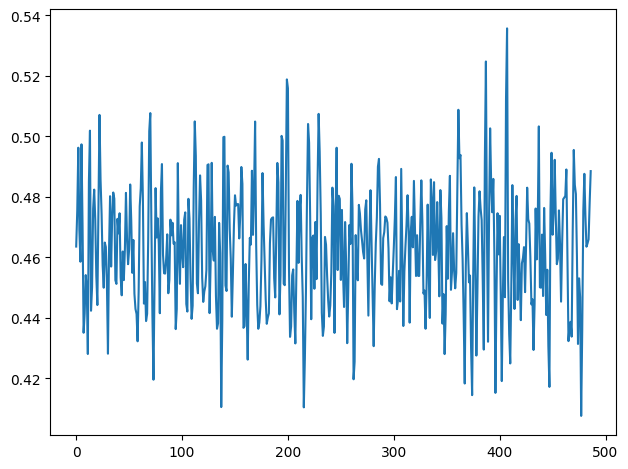

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
BASE_PATH = Path.cwd()
LOG_PATH = BASE_PATH / "log_qaia"
LOG_PATH.mkdir(exist_ok=True)
class ValueWindow:
    def __init__(self, nlen=10):
        self.values: List[float] = []
        self.nlen = nlen
    def add(self, v: float):
        self.values.append(v)
        self.values = self.values[-self.nlen :]
    @property
    def mean(self):
        return sum(self.values) / len(self.values) if self.values else 0.0
def load_data(limit: int) -> List[Tuple]:
    dataset = []
    folder = "train_dataset"
    files = sorted(os.listdir((folder)))
    N = 12
    for idx, filename in enumerate(tqdm(files)):
        if idx > limit > 0:
            break
        filepath = os.path.join(folder, filename)
        with open(filepath, "r") as f:
            data = json.load(f)
        h = np.zeros(N)
        J = np.zeros((N, N))
        hyperedges = data["J"]
        coeffs = data["c"]
        for edge, coef in zip(hyperedges, coeffs):
            if len(edge) == 1:
                h[edge[0]] += coef
            elif len(edge) == 2:
                i, j = edge
                J[i, j] += coef
                J[j, i] += coef
            else:
                print("warning: invalid input", edge)
        label = data.get("label", None)
        if label is not None:
            x = label.get("x", None)
        J = -J
        h = -h
        J = torch.tensor(J, dtype=torch.float32, device=device)
        h = torch.tensor(h, dtype=torch.float32, device=device).unsqueeze(1)
        x = (
            torch.tensor(x, dtype=torch.float32, device=device)
            if label is not None
            else None
        )
        dataset.append((J, h, x))
    return dataset
def train(args):
    print("device:", device)
    exp_name = f"DU-SB_T={args.n_iter}_lr={args.lr}"
    dataset = load_data(args.limit)
    model: DU_SB = globals()["DU_SB"](args.n_iter, args.batch_size).to(device)
    optim = Adam(model.parameters(), args.lr)
    init_step = 0
    losses = []
    if args.load:
        print(f">> resume from {args.load}")
        ckpt = torch.load(args.load, map_location="cpu")
        init_step = ckpt["steps"]
        losses.extend(ckpt["losses"])
        model.load_state_dict(ckpt["model"], strict=False)
        optim.load_state_dict(ckpt["optim"])
    loss_wv = ValueWindow(100)
    steps_minor = 0
    steps = init_step
    model.train()
    try:
        pbar = tqdm(total=args.steps - init_step)
        while steps < init_step + args.steps:
            if not args.no_shuffle and steps_minor % len(dataset) == 0:
                random.shuffle(dataset)
            sample = dataset[steps_minor % len(dataset)]
            J, h, bits = sample
            spins = model(J, h)
            loss_each = torch.stack([ber_loss(sp, bits, args.loss_fn) for sp in spins])
            loss = getattr(loss_each, args.agg_fn)()
            loss_for_backward: Tensor = loss / args.grad_acc
            loss_for_backward.backward()
            loss_wv.add(loss.item())
            steps_minor += 1
            if args.grad_acc == 1 or steps_minor % args.grad_acc:
                optim.step()
                optim.zero_grad()
                steps += 1
                pbar.update()
            if steps % 50 == 0:
                losses.append(loss_wv.mean)
    except KeyboardInterrupt:
        pass
    ckpt = {
        "steps": steps,
        "losses": losses,
        "model": model.state_dict(),
        "optim": optim.state_dict(),
    }
    torch.save(ckpt, LOG_PATH / f"{exp_name}.pth")
    with torch.no_grad():
        params = {
            "deltas": model.Δ.detach().cpu().numpy().tolist(),
            "eta": model.η.detach().cpu().item(),
            "a": model.a.detach().cpu().numpy().tolist(),
        }
        with open(LOG_PATH / f"{exp_name}.json", "w", encoding="utf-8") as fh:
            json.dump(params, fh, indent=2, ensure_ascii=False)
    plt.plot(losses)
    plt.tight_layout()
    plt.savefig(LOG_PATH / f"{exp_name}.png", dpi=600)
def ber_loss(spins: Tensor, bits: Tensor, loss_fn: str = "mse") -> Tensor:
    bits_final = (spins + 1) / 2
    if loss_fn in ["l2", "mse"]:
        return F.mse_loss(bits_final, bits)
    if loss_fn in ["l1", "mae"]:
        return F.l1_loss(bits_final, bits)
    if loss_fn == "bce":
        pseudo_logits = bits_final * 2 - 1
        return F.binary_cross_entropy_with_logits(pseudo_logits, bits)
    raise ValueError(f"Unsupported loss function: {loss_fn}")
parser = ArgumentParser()
parser.add_argument("-T", "--n_iter", default=15, type=int)
parser.add_argument(
    "-B", "--batch_size", default=32, type=int, help="SB candidate batch size")
parser.add_argument("--steps", default=20000, type=int)
parser.add_argument("--loss_fn", default="bce", choices=["mse", "l1", "bce"])
parser.add_argument("--agg_fn", default="mean", choices=["mean", "max"])
parser.add_argument("--grad_acc", default=1, type=int, help="training batch size")
parser.add_argument("--lr", default=1e-4, type=float)
parser.add_argument("--load", help="ckpt to resume")
parser.add_argument(
    "-L", "--limit", default=-1, type=int, help="limit dataset n_sample")
parser.add_argument("--overfit", action="store_true", help="overfit to given dataset")
parser.add_argument("--no_shuffle", action="store_true", help="no shuffle dataset")
parser.add_argument("--log_every", default=50, type=int)
args, unknown = parser.parse_known_args()
if args.overfit:
    print("[WARN] you are trying to overfit to the given dataset!")
train(args)

### 3.4 测试结果

在并行数和迭代周期数一致的情况下，DUSB的能量值低于SB，实现了求解质量的提升。Gurobi的能量值最小，但是计算效率较低。

In [9]:
σ = lambda x: 1 / (1 + np.exp(-x))
sw = lambda x: x * σ(x)
φ_s = lambda x, Λ=10: (1 / Λ) * (sw(Λ * (x + 1)) - sw(Λ * (x - 1))) - 1
ψ_s = lambda x, A=100, B=1.01: σ(A * (np.abs(x) - B))
class DUSB(BSB):
    def __init__(self, J: ndarray, h: ndarray, deltas: List[float], eta: float, a: List[float], x: ndarray = None, batch_size: int = 100):
        super().__init__(J, h, x, len(deltas), batch_size, dt=1, xi=None)
        self.N = self.J.shape[0]
        if self.x is None:
            self.x = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)
        if self.y is None:
            self.y = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)
        self.Δ = deltas
        self.η = eta
        self.c_0 = self.xi * self.η
        self.a_m1 = np.array(a) - 1
    def update(self):
        for k, Δ_k in enumerate(self.Δ):
            self.y += Δ_k * (self.a_m1[k] * self.x + self.c_0 * (self.J @ self.x + self.h))
            self.x += Δ_k * self.y
            self.x = φ_s(self.x)
            self.y *= 1 - ψ_s(self.x)
    def update_hard(self):
        for k, Δ_k in enumerate(self.Δ):
            self.y += Δ_k * (self.a_m1[k] * self.x + self.c_0 * (self.J @ self.x + self.h))
            self.x += Δ_k * self.y
            cond = np.abs(self.x) > 1
            self.x = np.where(cond, np.sign(self.x), self.x)  # limit x to vrng [-1, +1]
            self.y = np.where(cond, np.zeros_like(self.x), self.y)

In [10]:
BASE_PATH = Path.cwd()
LOG_PATH = BASE_PATH / "log_qaia"
def solver_qaia_lib(qaia_cls, J: ndarray, h: ndarray, n_iter) -> ndarray:
    bs = 1
    solver: QAIA = qaia_cls(J, h, batch_size=bs, n_iter=n_iter)
    solver.update()  # [rb*N, B]
    if bs > 1:
        energy = min(solver.calc_energy())  # [1, B]
    else:
        energy = min(solver.calc_energy())
    return energy
def solver_DU_SB(J: ndarray, h: ndarray, deltas, eta, a) -> ndarray:
    bs = 1
    solver = DUSB(J, h, deltas, eta, a, batch_size=bs)
    solver.update_hard()  # [rb*N, B]
    if bs > 1:
        energy = min(solver.calc_energy())  # [1, B]
    else:
        energy = min(solver.calc_energy())
    return energy
def qaia_mld_solver(J: ndarray, h: ndarray, run_cfg, DU_SB_weights) -> ndarray:
    filename = DU_SB_weights.name
    pattern = r"T=(\d+)"
    match = re.search(pattern, filename)
    n_iter = int(match.group(1))
    with open(DU_SB_weights, "r", encoding="utf-8") as fh:
        params = json.load(fh)
        deltas: List[float] = params["deltas"]
        eta: float = params["eta"]
        a: float = params["a"]
    if run_cfg == "baseline":
        return solver_qaia_lib(BSB, J, h, n_iter)
    return solver_DU_SB(J, h, deltas, eta, a)

100%|██████████| 90/90 [00:00<00:00, 1052.51it/s]


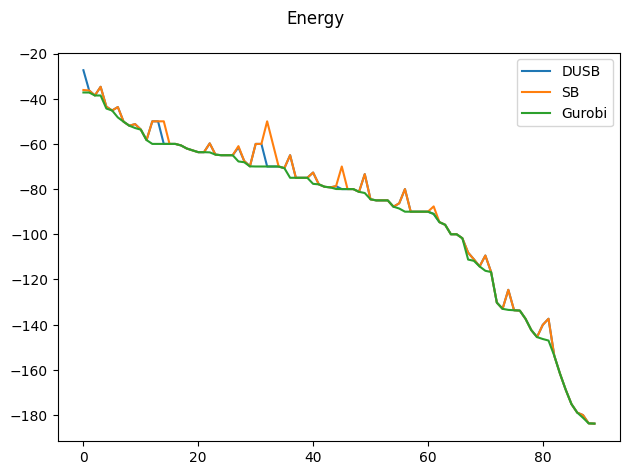

>> Method: DUSB
>> time cost: 0.11
>> avg. energy = -88.43656
>> Method: SB
>> time cost: 0.09
>> avg. energy = -87.93552
>> avg. obj = -90.05924


In [11]:
# run_cfg='baseline'
run_cfg = "DU_SB"
BASE_PATH = Path.cwd()
LOG_PATH = BASE_PATH / "log_qaia"
DU_SB_weights = LOG_PATH / "DU-SB_T=15_lr=0.0001.json"
class Judger:
    def __init__(self, test_cases):
        self.test_cases = test_cases
    @staticmethod
    def infer(J, h, qaia_mld_solver):
        bits = qaia_mld_solver(J, h, run_cfg, DU_SB_weights)
        return bits
    def benchmark(self, qaia_mld_solver):
        energy_list = []
        obj_list = []
        avgenergy = 0
        avgobj = 0
        t1 = time.time()
        for case in tqdm(self.test_cases):
            J, h, obj_val = case
            energy = self.infer(J, h, qaia_mld_solver)
            avgenergy += energy[0]
            energy_list.append(energy)
        t2 = time.time()
        global run_cfg
        avgsbenergy = 0
        run_cfg = "baseline"
        sbenergy_list = []
        t3 = time.time()
        for case in tqdm(self.test_cases):
            J, h, obj_val = case
            energy = self.infer(J, h, qaia_mld_solver)
            avgsbenergy += energy[0]
            avgobj += obj_val
            sbenergy_list.append(energy)
            obj_list.append(obj_val)
        t4 = time.time()
        avgobj /= len(self.test_cases)
        avgenergy /= len(self.test_cases)
        avgsbenergy /= len(self.test_cases)
        BASE_PATH = Path.cwd()
        LOG_PATH = BASE_PATH / "log_qaia"
        LOG_PATH.mkdir(exist_ok=True)
        pairs = list(zip(obj_list, energy_list, sbenergy_list))
        pairs.sort(reverse=True)
        DUSB_list = [D_energy for G_energy, D_energy, SB_energy in pairs]
        SB_list = [SB_energy for G_energy, D_energy, SB_energy in pairs]
        Gurobi_list = [G_energy for G_energy, D_energy, SB_energy in pairs]
        plt.plot(DUSB_list, label=f"DUSB")
        plt.plot(SB_list, label=f"SB")
        plt.plot(Gurobi_list, label="Gurobi")
        plt.legend()
        plt.suptitle("Energy")
        plt.tight_layout()
        plt.savefig(LOG_PATH / "solut.png", dpi=400)
        plt.show()
        plt.close()
        tt1 = t2 - t1
        tt2 = t4 - t3
        return avgenergy, avgsbenergy, avgobj, tt1, tt2

dataset = []
folder = "test_dataset"
files = sorted(os.listdir(folder))
N = 12  # 固定变量数
for idx, filename in enumerate(tqdm(files)):
    filepath = os.path.join(folder, filename)
    with open(filepath, "r") as f:
        data = json.load(f)
    h = np.zeros(N)
    J = np.zeros((N, N))
    hyperedges = data["J"]
    coeffs = data["c"]
    for edge, coef in zip(hyperedges, coeffs):
        if len(edge) == 1:
            h[edge[0]] += coef
        elif len(edge) == 2:
            i, j = edge
            J[i, j] += coef
            J[j, i] += coef
        else:
            print("warning: invalid input", edge)
    label = data.get("label", None)
    if label is not None:
        obj_val = label.get("obj_val", None)
    J = -J
    h = -h
    dataset.append((J, h, obj_val))
judger = Judger(dataset)
avgenergy, avgsbenergy, avgobj, tt1, tt2 = judger.benchmark(qaia_mld_solver)
print(f">> Method: DUSB")
print(f">> time cost: {tt1:.2f}")
print(f">> avg. energy = {avgenergy:.5f}")
print(f">> Method: SB")
print(f">> time cost: {tt2:.2f}")
print(f">> avg. energy = {avgsbenergy:.5f}")
print(f">> avg. obj = {avgobj:.5f}")

## 4 项目总结

综上所述，本项目基于 MindSpore Quantum 将弹道模拟分岔机算法转换为可微的形式，然后利用梯度下降法实现了深度展开量子启发式算法。该算法可以自动调参，改善求解性能。比较了不同案例下基线方法和深度展开方法的计算效果，结果与预期一致。

## 参考文献

[1] Goto H, Endo K, Suzuki M, et al. High-performance combinatorial optimization based on classical mechanics[J]. Science Advances, 2021, 7(6): eabe7953.

[2] Zeng Q G, Cui X P, Liu B, et al. Performance of quantum annealing inspired algorithms for combinatorial optimization problems[J]. Communications Physics, 2024, 7(1): 249.

[3] Takabe S. Deep unfolded simulated bifurcation for massive MIMO signal detection[J]. arXiv preprint arXiv:2306.16264, 2023.